# 🐝🎵 Introduction to XyloAudio 3

In [1]:
# - Used to build trainable models
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# - Modules required to interface and deploy models to the Xylo-IMU HDK
from rockpool.devices.xylo import find_xylo_hdks
from rockpool.devices.xylo.syns65302 import XyloSamna, config_from_specification

from rockpool.devices.xylo.syns63300 import (
    mapper,
    XyloSim,
)
from rockpool.transform import quantize_methods as q

# - Used for plotting time series
from rockpool import TSEvent, TSContinuous
import numpy as np
import matplotlib.pyplot as plt

from samna.xyloA3.configuration import InputInterfaceConfig


In [2]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-2

In [3]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias=False),
    LIFTorch(Nhidden, dt=dt),
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias=False),
        LIFTorch(Nhidden, has_rec=True, threshold=1.0, dt=dt),
    ),
    LinearTorch((Nhidden, Nout), has_bias=False),
    LIFTorch(Nout, dt=dt),
)
print(net)

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}


In [4]:
# - Call the Xylo mapper on the extracted computational graph
spec = mapper(
    net.as_graph(), weight_dtype="float", threshold_dtype="float", dash_dtype="float"
)

# - Quantize the specification
spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

# - Use `config_from_specification()` to convert it to a hardware configuration
config, is_valid, msg = config_from_specification(**spec)
if not is_valid:
    print(msg)

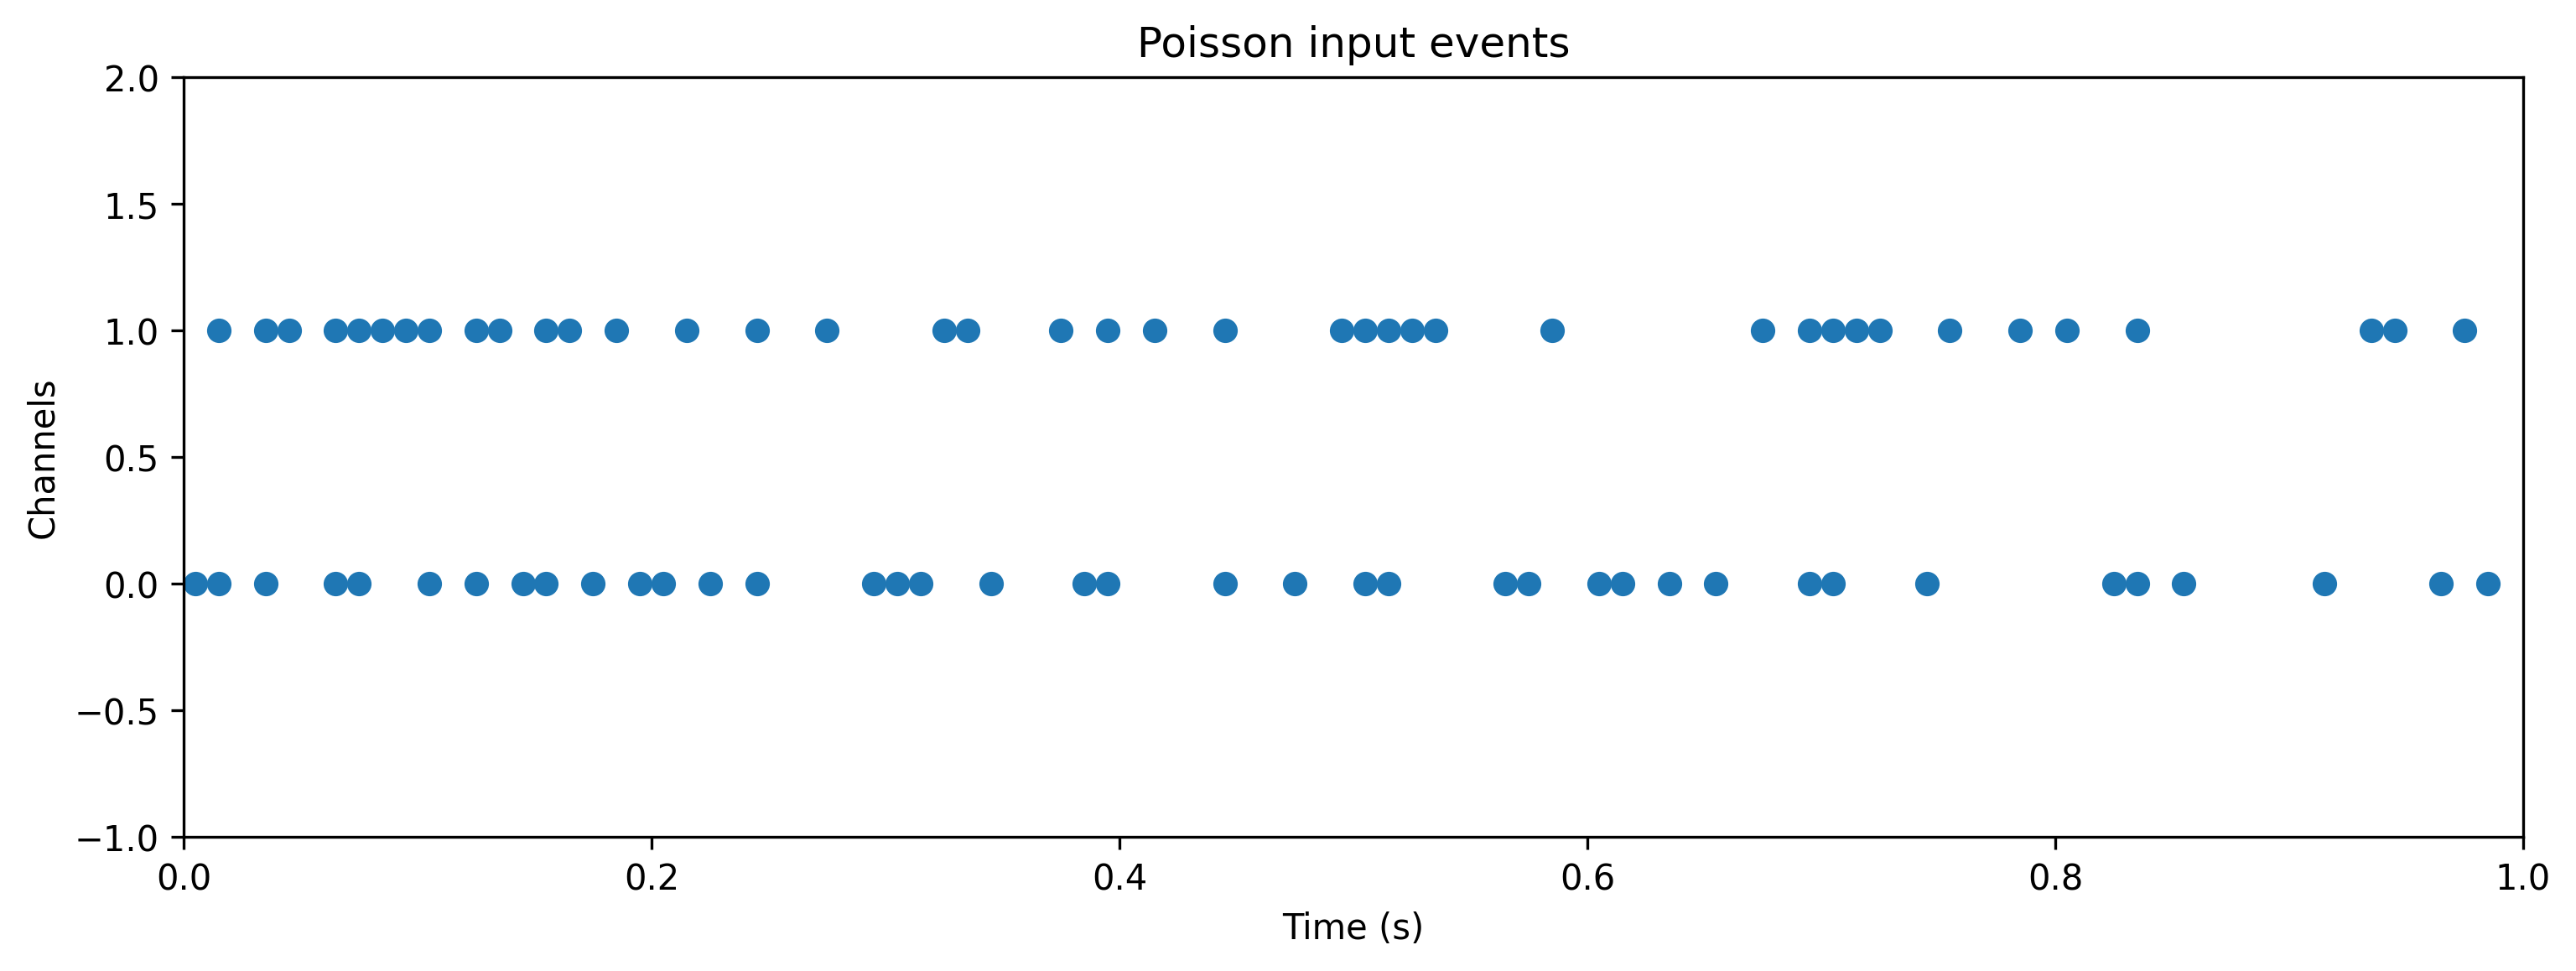

In [5]:
# - Generate some Poisson input
T = 100
f = 0.4
input_spikes = np.random.rand(T, Nin) < f
plt.figure(figsize=(12, 4), dpi=300)
TSEvent.from_raster(input_spikes, dt, name="Poisson input events").plot()

In [6]:
# - Use the XyloIMUSim device simulator
modSim = XyloSim.from_config(config, dt=dt)
print(modSim)

XyloSim  with shape (16, 1000, 8)


In [7]:
# - Evolve the input over the network, in simulation
out, _, r_d = modSim(input_spikes, record=True)

# - Show the internal state variables recorded
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Spikes', 'Vmem_out', 'Isyn_out'])


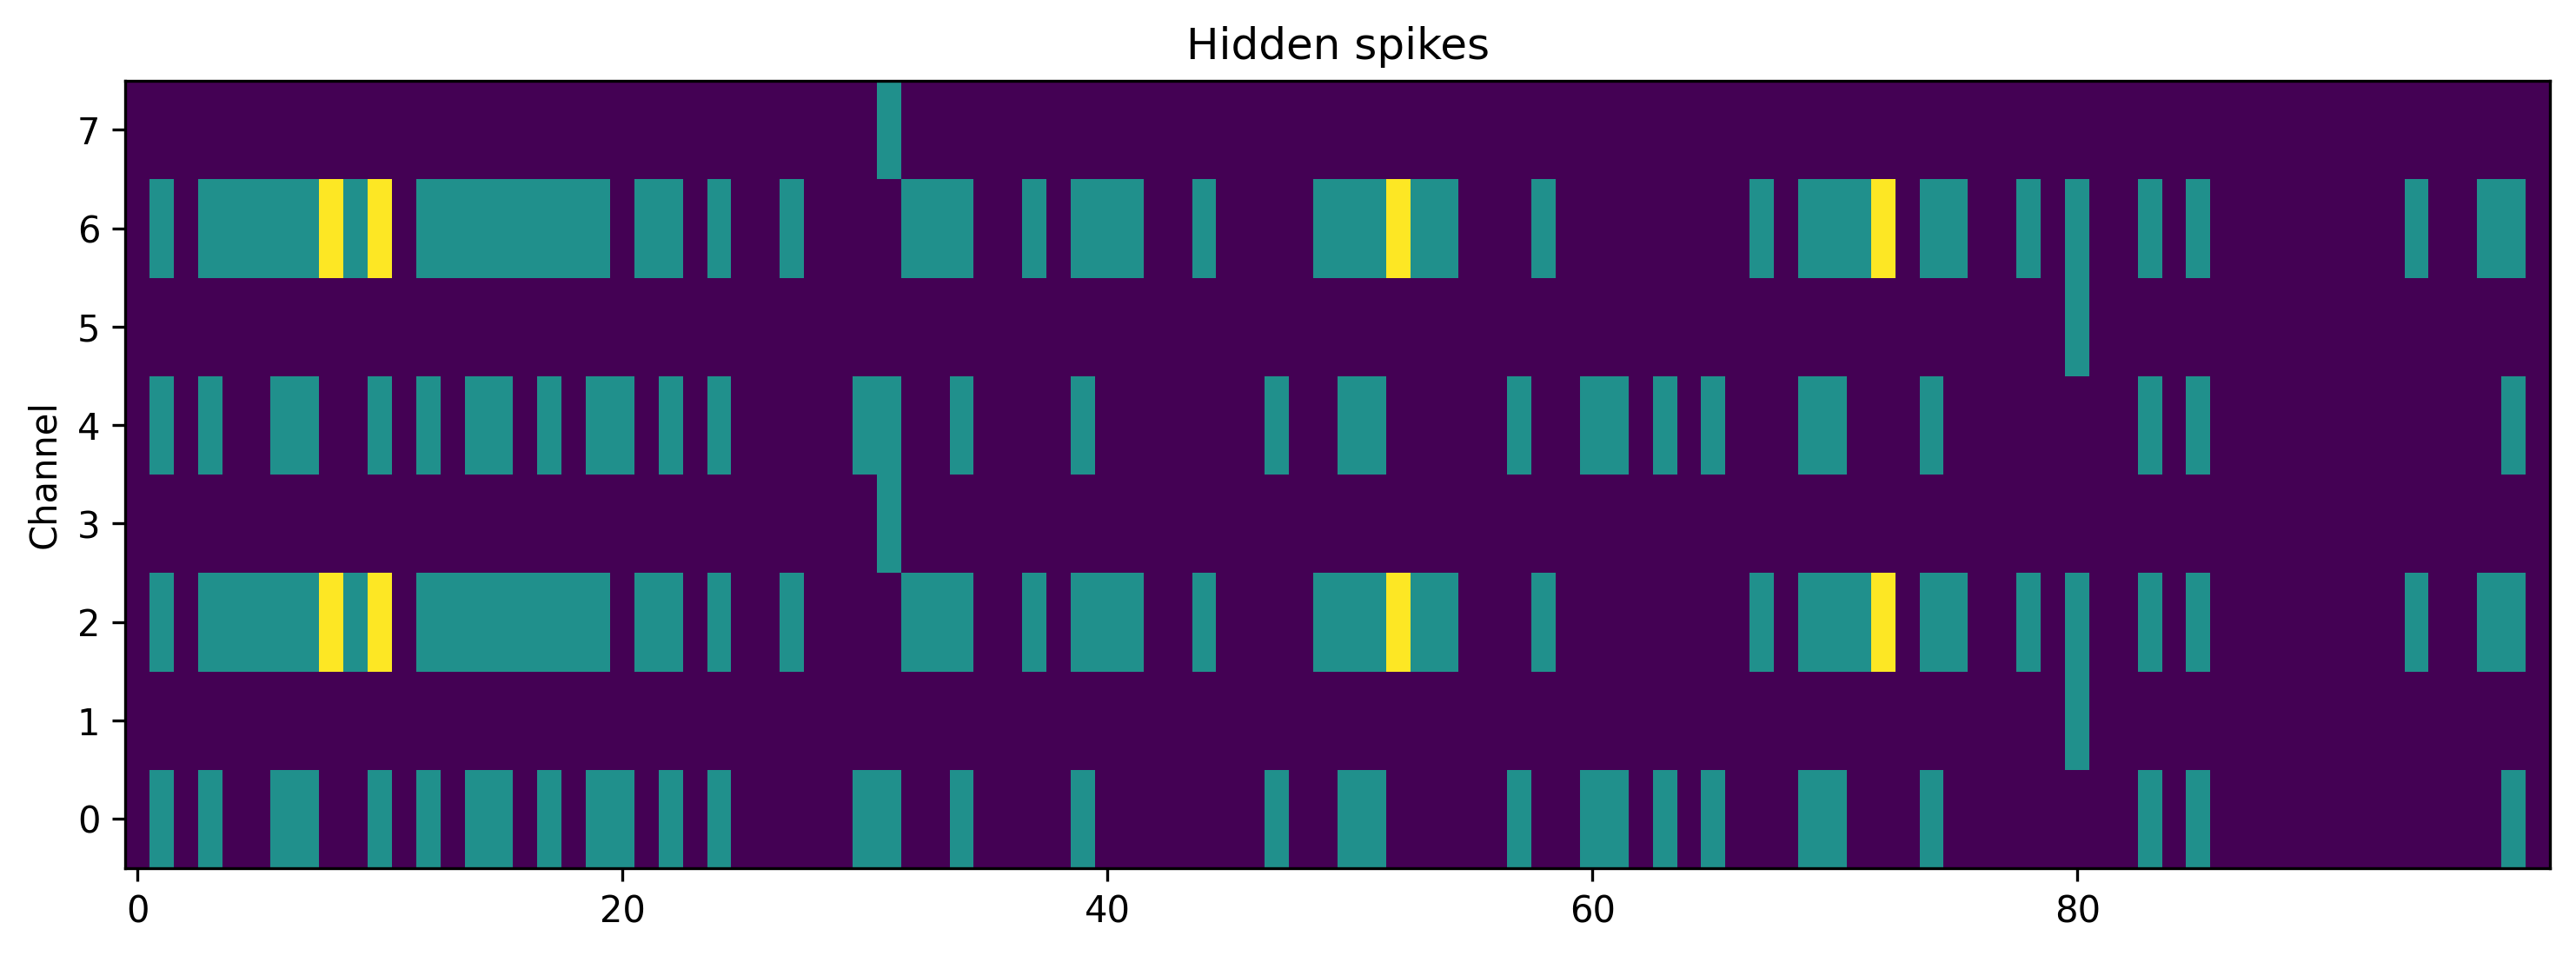

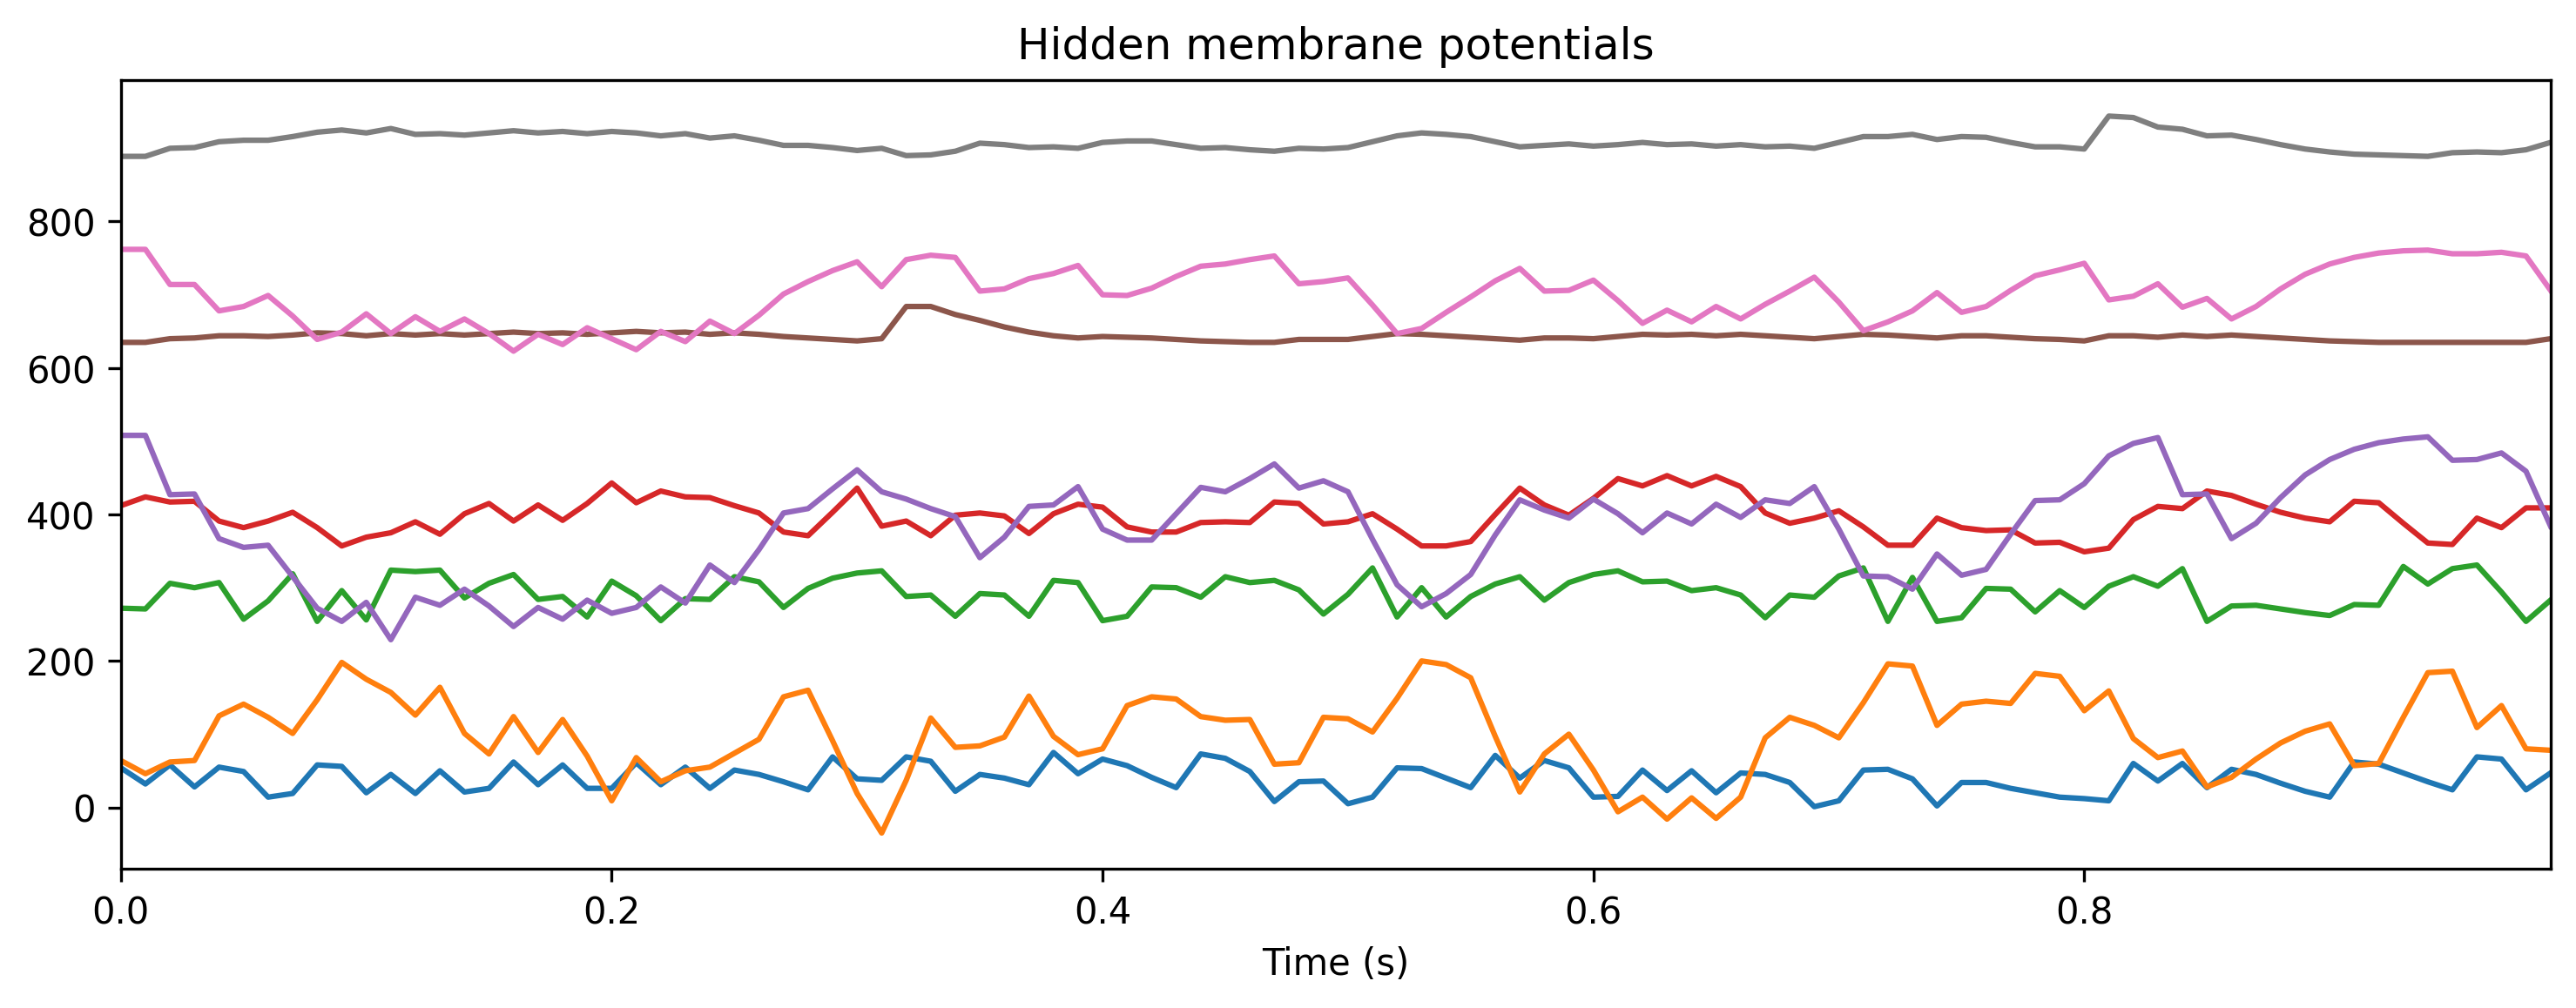

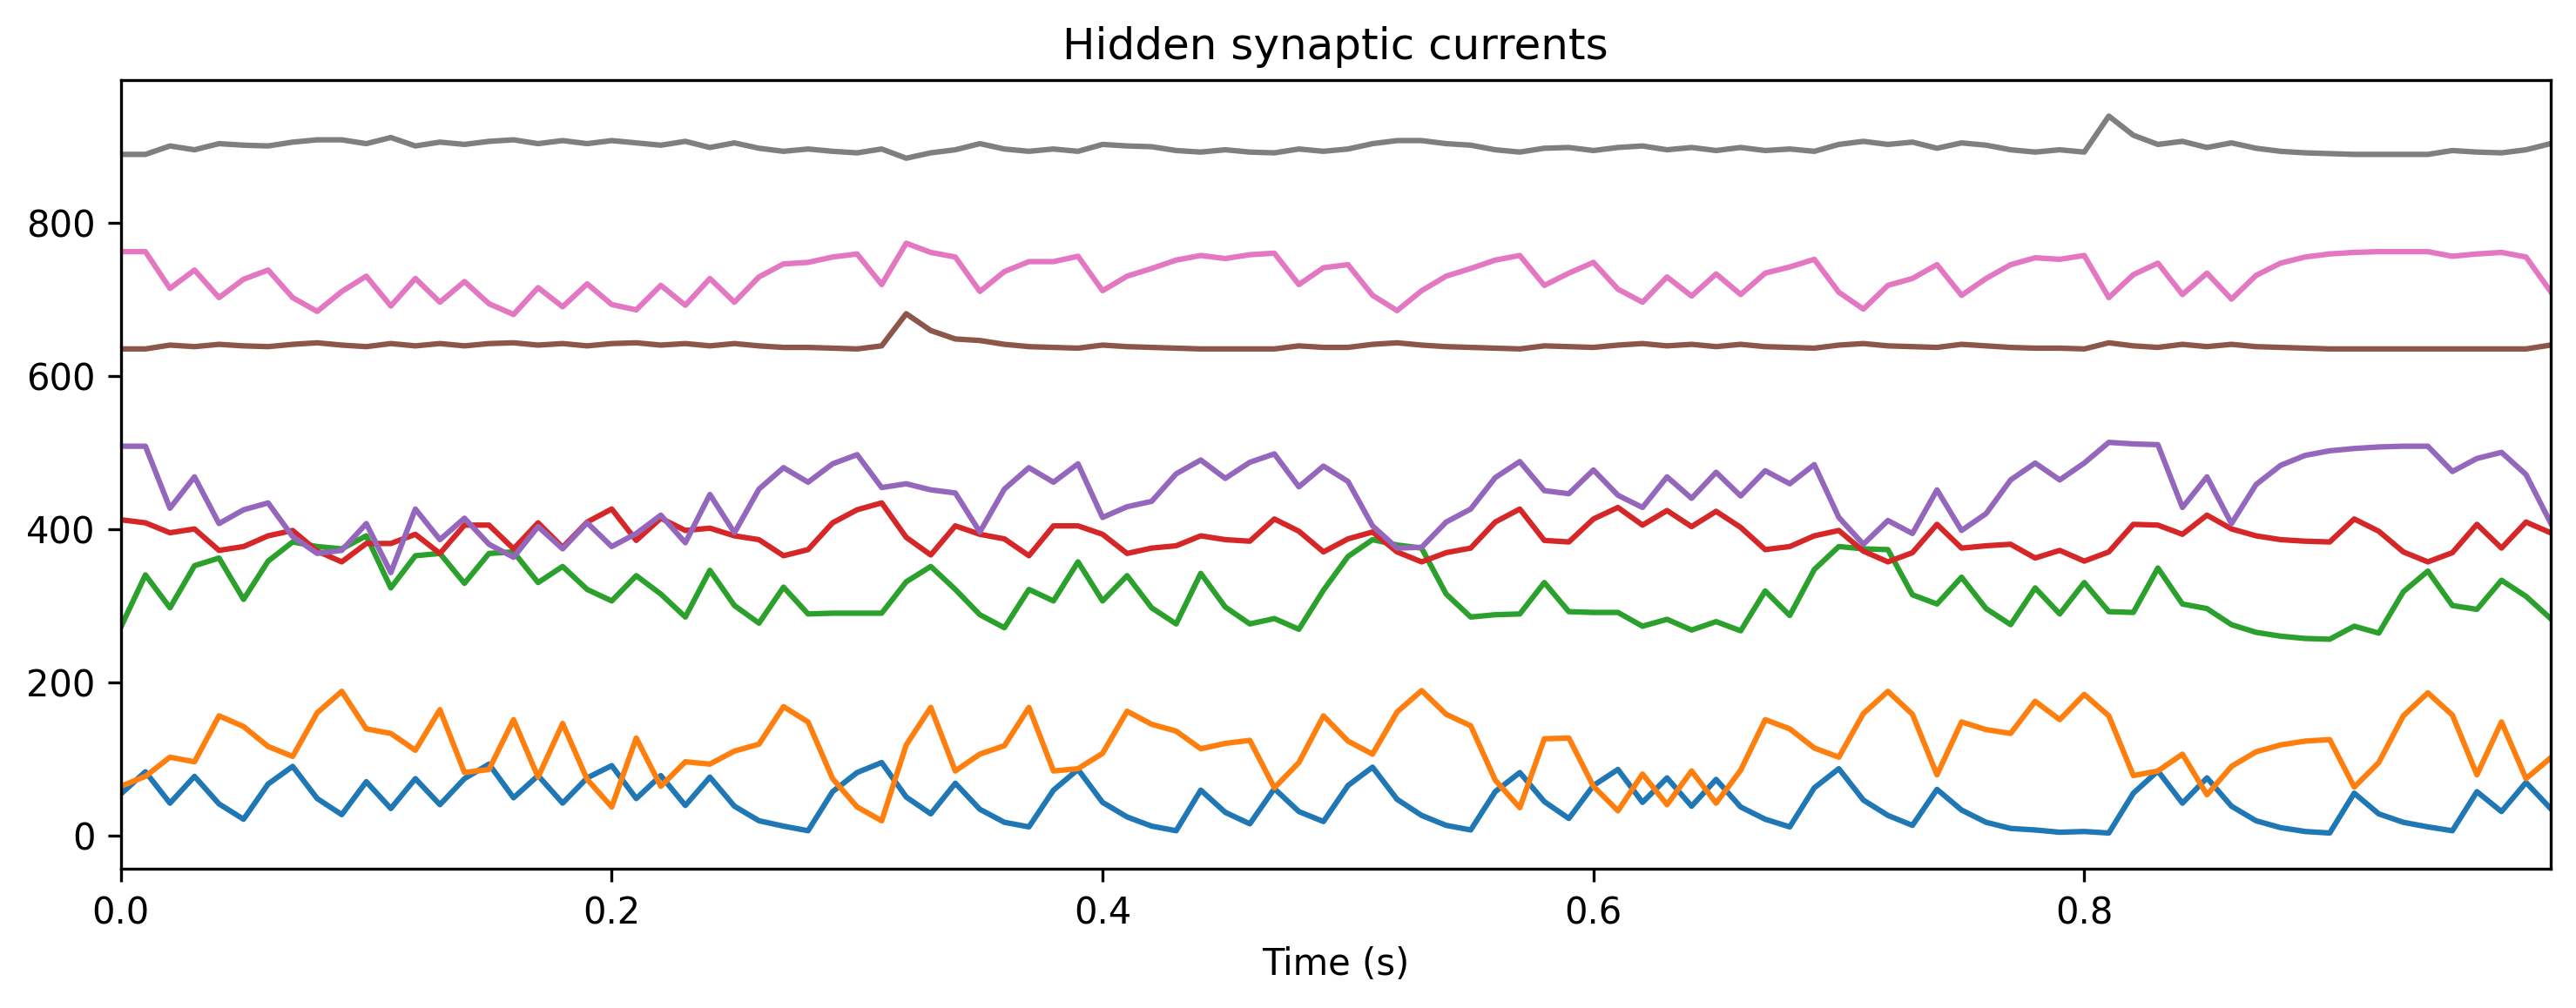

In [8]:
# - Plot some internal state variables
plt.figure(figsize=(12, 4), dpi=300)
plt.imshow(r_d["Spikes"].T, aspect="auto", origin="lower")
plt.title("Hidden spikes")
plt.ylabel("Channel")

plt.figure(figsize=(12, 4), dpi=300)
TSContinuous.from_clocked(r_d["Vmem"], dt, name="Hidden membrane potentials").plot(
    stagger=127
)

plt.figure(figsize=(12, 4), dpi=300)
TSContinuous.from_clocked(r_d["Isyn"], dt, name="Hidden synaptic currents").plot(
    stagger=127
)

In [9]:
# - Find and connect to a Xylo IMU HDK
xylo_hdk_nodes, _, vers = find_xylo_hdks()
print(xylo_hdk_nodes, vers)

if len(xylo_hdk_nodes) == 0 or vers[0] != "syns65302":
    assert False, "This tutorial requires a connected XyloAudio 3 HDK to demonstrate."
else:
    db = xylo_hdk_nodes[0]

The connected Xylo HDK contains a Xylo A3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloAudio3Boards.XyloAudio3TestBoard object at 0x2babe9cf0>] ['syns65302']


In [10]:
# - Use the `XyloSamna` module to deploy to the inference core on the HDK
modSamna = XyloSamna(db, config, dt=dt)
print(modSamna)

XyloSamna  with shape (2, 8, 2)


In [11]:
r_d.keys()

dict_keys(['Vmem', 'Isyn', 'Spikes', 'Vmem_out', 'Isyn_out'])

Text(0, 0.5, 'Channel')

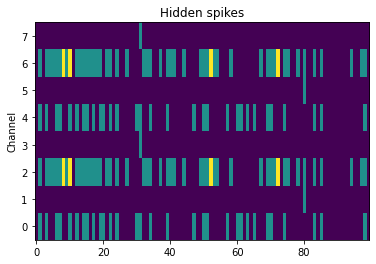

In [12]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d["Spikes"].T, aspect="auto", origin="lower")
plt.title("Hidden spikes")
plt.ylabel("Channel")

# plt.figure()
# TSContinuous(r_d["times"], r_d["Vmem"], name="Hidden membrane potentials").plot(
#     stagger=127
# )

# plt.figure()
# TSContinuous(r_d["times"], r_d["Isyn"], name="Hidden synaptic currents").plot(
#     stagger=127
# )